# LSTM
Test BiLSTM with Embedding. No learning after first epoch. Random variation to loss. This ran for 24 hours on Windows. 

Inputs were lists of numbers, 0-63. Any K-mer with N was coded zero. AAA=NCG=0. Let Keras Embedding create the one-hot vectors. (However, the sequences are N-padded and we could not get mask_zero to work. The K-mer AAA was coded zero as was any K-mer with an N.) Tried 0-64 with N=0, A=1 but could not get Keras Embedding to work with mask_zero=True. Dies deep in the code. May be a bug. Decide to try Keras Masking layer later.

RNA len 1K-4K (31220 seqs). Coding train. Mac. Cell line H1.hESC. Model: Embed 16; Bidirectional LSTM 32 [which means 64 cells], default act, return seq = True; Dense 16 sigmoid, Dropout 50%, Dense 1. Trainable parameters = 14625. 5fcv with 10 epochs. 

Learning curves vary randomly. Loss stays around 0.64. Train acc usually grows from ~55% to ~65%. Val acc 65.87% +/- 3.58. 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-17 09:35:25.176811
Python 3.10.6
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=3
EPOCHS=10
FOLDS=5  
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
MINLEN=1000

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows

In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-17 09:35:29.371625
Num RCI: 13000
[('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]


In [7]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3, 'N':0}
    length = len(rna)
    vec = []
    for i in range(length-K+1):
        one_hot = 0
        for j in range(K):
            one_hot = one_hot * 4
            nextnuc = rna[i+j]
            if nextnuc=='N':
                one_hot= 0   # Same as A? Come back to this and try mask_zero=True
                break
            nucval = VALS[nextnuc]
            one_hot = one_hot + nucval
        vec.append(one_hot)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[0, 0]
[19, 15]
[62, 56]
[63, 0]


In [8]:
# one hot
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-11-17 09:35:29.424998
Load sequence
2022-11-17 09:36:18.146599
Num IDs: 31220
Num labels: 31220
Num counts: 31220


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [21]:
def build_model():
    ALPHABET=4**K  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,mask_zero=False);   # crashes with mask_value=True
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    dropout1_layer = Dropout(0.50)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [22]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-17 10:04:20.920812
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          1024      
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 64)         12544     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, None, 16)          1040      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 dense_13 (Dense)            (None, None, 1)           17        
                                                                 
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
_______________

In [23]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
    print()
    return cv_scores
print(datetime.now())

2022-11-17 10:04:21.411389


Issues to address:

Reduce dtype to int8?
Call arguments received by layer "sequential" "                 f"(type Sequential):
inputs=tf.Tensor(shape=(None, 4000, 4), dtype=int32)

The genes were shuffled but the transcripts were not.  
That could retard training.

Loading sequence takes minutes. Save one-hot dataset to binary file. 

Loading sequence takes RAM. A numpy array of one-hot might require less RAM. Write a just-in-time loader.

Accuracy goes down at the start of each epoch. This could mean that the data are not shuffled sufficiently.

2022-11-17 10:04:22.867675
2022-11-17 10:04:22.867675
splitting
Fold 1
Train sizes (24903, 3998) (24903, 1)
Valid sizes (6317, 3998) (6317, 1)
Train set ones/size 12187 / 24903
Valid set ones/size 3025 / 6317
BUILD MODEL
COMPILE
FIT
2022-11-17 10:04:29.389978
Epoch 1/10
779/779 [==============================] - 1431s 2s/step - loss: 0.6876 - accuracy: 0.5435 - val_loss: 0.6680 - val_accuracy: 0.5567
Epoch 2/10
779/779 [==============================] - 1461s 2s/step - loss: 0.6691 - accuracy: 0.5868 - val_loss: 0.6741 - val_accuracy: 0.5706
Epoch 3/10
779/779 [==============================] - 1470s 2s/step - loss: 0.6577 - accuracy: 0.6209 - val_loss: 0.6506 - val_accuracy: 0.6287
Epoch 4/10
779/779 [==============================] - 1460s 2s/step - loss: 0.6520 - accuracy: 0.6317 - val_loss: 0.6480 - val_accuracy: 0.6241
Epoch 5/10
779/779 [==============================] - 1427s 2s/step - loss: 0.6508 - accuracy: 0.6218 - val_loss: 0.6447 - val_accuracy: 0.6371
Epoch 6/10
779/779 [

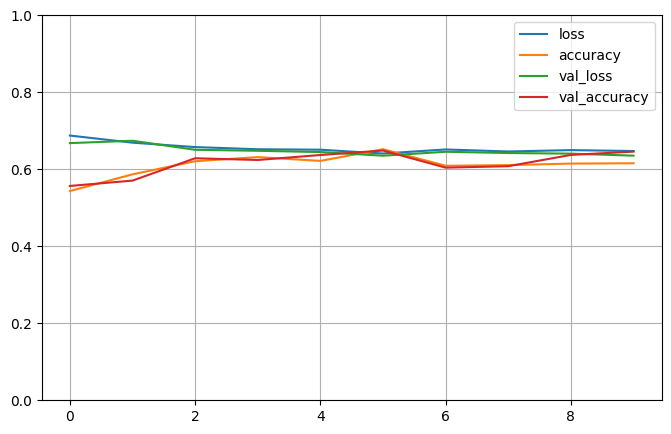

Compute valiation accuracy
2022-11-17 14:09:22.189463
accuracy: 64.58%
2022-11-17 14:10:05.526654
Fold 2
Train sizes (24921, 3998) (24921, 1)
Valid sizes (6299, 3998) (6299, 1)
Train set ones/size 12133 / 24921
Valid set ones/size 3079 / 6299
BUILD MODEL
COMPILE
FIT
2022-11-17 14:10:12.042006
Epoch 1/10
779/779 [==============================] - 1584s 2s/step - loss: 0.6930 - accuracy: 0.5281 - val_loss: 0.6678 - val_accuracy: 0.5855
Epoch 2/10
779/779 [==============================] - 1460s 2s/step - loss: 0.6782 - accuracy: 0.5675 - val_loss: 0.6722 - val_accuracy: 0.5768
Epoch 3/10
779/779 [==============================] - 1506s 2s/step - loss: 0.6747 - accuracy: 0.5721 - val_loss: 0.6672 - val_accuracy: 0.5929
Epoch 4/10
779/779 [==============================] - 1506s 2s/step - loss: 0.6565 - accuracy: 0.6266 - val_loss: 0.6534 - val_accuracy: 0.6024
Epoch 5/10
779/779 [==============================] - 1480s 2s/step - loss: 0.6439 - accuracy: 0.6493 - val_loss: 0.6188 - val_acc

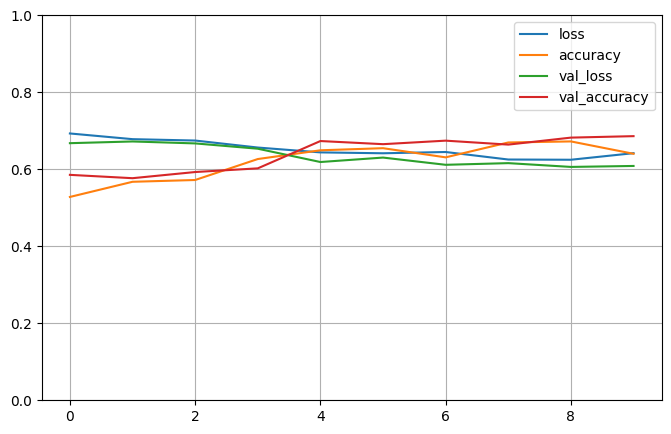

Compute valiation accuracy
2022-11-17 18:21:33.590028
accuracy: 68.60%
2022-11-17 18:22:18.035755
Fold 3
Train sizes (24914, 3998) (24914, 1)
Valid sizes (6306, 3998) (6306, 1)
Train set ones/size 12233 / 24914
Valid set ones/size 2979 / 6306
BUILD MODEL
COMPILE
FIT
2022-11-17 18:22:24.579546
Epoch 1/10
779/779 [==============================] - 1609s 2s/step - loss: 0.6790 - accuracy: 0.5677 - val_loss: 0.6681 - val_accuracy: 0.5948
Epoch 2/10
779/779 [==============================] - 1641s 2s/step - loss: 0.6659 - accuracy: 0.5996 - val_loss: 0.6465 - val_accuracy: 0.6335
Epoch 3/10
779/779 [==============================] - 1733s 2s/step - loss: 0.6743 - accuracy: 0.5764 - val_loss: 0.6656 - val_accuracy: 0.5735
Epoch 4/10
779/779 [==============================] - 1730s 2s/step - loss: 0.6714 - accuracy: 0.5867 - val_loss: 0.6756 - val_accuracy: 0.5883
Epoch 5/10
779/779 [==============================] - 1638s 2s/step - loss: 0.6751 - accuracy: 0.5664 - val_loss: 0.6704 - val_acc

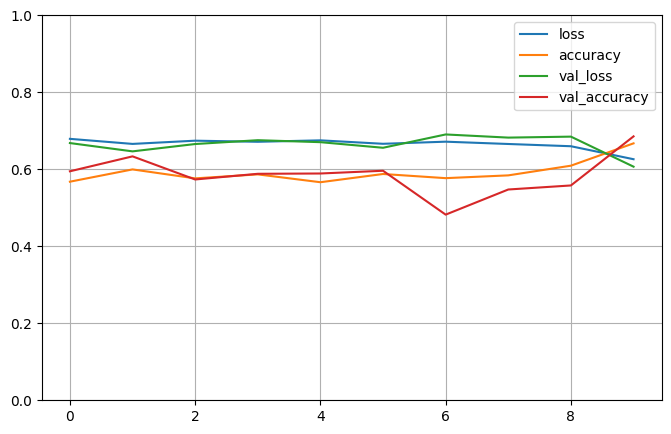

Compute valiation accuracy
2022-11-17 22:59:07.860030
accuracy: 68.55%
2022-11-17 22:59:51.904591
Fold 4
Train sizes (24986, 3998) (24986, 1)
Valid sizes (6234, 3998) (6234, 1)
Train set ones/size 12223 / 24986
Valid set ones/size 2989 / 6234
BUILD MODEL
COMPILE
FIT
2022-11-17 22:59:58.457086
Epoch 1/10
781/781 [==============================] - 1757s 2s/step - loss: 0.6915 - accuracy: 0.5398 - val_loss: 0.6696 - val_accuracy: 0.5897
Epoch 2/10
781/781 [==============================] - 1743s 2s/step - loss: 0.6773 - accuracy: 0.5699 - val_loss: 0.6852 - val_accuracy: 0.5379
Epoch 3/10
781/781 [==============================] - 1742s 2s/step - loss: 0.6898 - accuracy: 0.5184 - val_loss: 0.6760 - val_accuracy: 0.5205
Epoch 4/10
781/781 [==============================] - 1738s 2s/step - loss: 0.6900 - accuracy: 0.5200 - val_loss: 0.6903 - val_accuracy: 0.5352
Epoch 5/10
781/781 [==============================] - 1742s 2s/step - loss: 0.6820 - accuracy: 0.5559 - val_loss: 0.6723 - val_acc

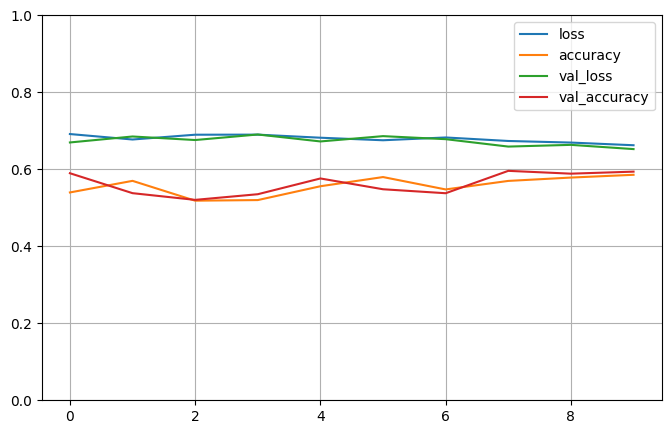

Compute valiation accuracy
2022-11-18 03:51:14.759239
accuracy: 59.39%
2022-11-18 03:51:58.238192
Fold 5
Train sizes (25156, 3998) (25156, 1)
Valid sizes (6064, 3998) (6064, 1)
Train set ones/size 12072 / 25156
Valid set ones/size 3140 / 6064
BUILD MODEL
COMPILE
FIT
2022-11-18 03:52:04.716856
Epoch 1/10
787/787 [==============================] - 1770s 2s/step - loss: 0.6856 - accuracy: 0.5393 - val_loss: 0.6727 - val_accuracy: 0.5762
Epoch 2/10
787/787 [==============================] - 1765s 2s/step - loss: 0.6805 - accuracy: 0.5548 - val_loss: 0.6568 - val_accuracy: 0.6219
Epoch 3/10
787/787 [==============================] - 1766s 2s/step - loss: 0.6574 - accuracy: 0.6278 - val_loss: 0.6703 - val_accuracy: 0.5785
Epoch 4/10
787/787 [==============================] - 1766s 2s/step - loss: 0.6815 - accuracy: 0.5593 - val_loss: 0.6827 - val_accuracy: 0.5406
Epoch 5/10
787/787 [==============================] - 1731s 2s/step - loss: 0.6650 - accuracy: 0.6038 - val_loss: 0.6514 - val_acc

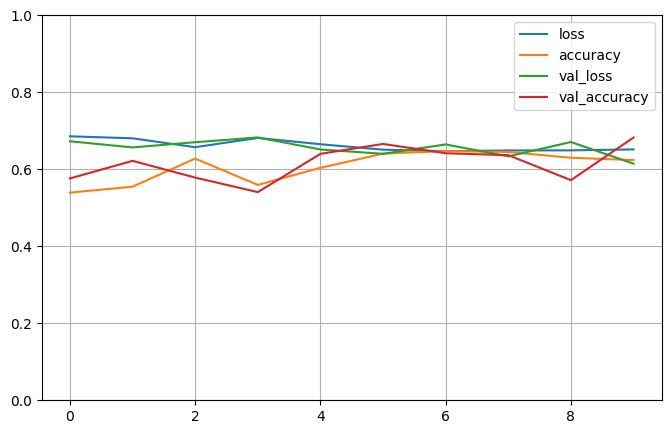

Compute valiation accuracy
2022-11-18 08:41:47.648379
accuracy: 68.25%
2022-11-18 08:42:29.401296

Cross validation acc mean 65.87% (+/- 3.58%)
2022-11-18 08:42:29.401296


In [24]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())